In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import h5py, os

In [4]:
"""
The dataset contains 1000 snapshots of the vorticity 
of the flow past a cylinder at Reynolds number, Re = 200.

Vorticity: Rotation of the fluid at a particular point. 
Mathematically its the curl of the velocity field

"""

data_set = "cyldata1k.csv"

U = np.loadtxt(data_set, delimiter=",")

nx = 768 # number of grid points in x direction
ny = 192 # number of grid points in y direction

"""
A grid point is a discrete location in space where the cfd simulation stores a value. 
Here that value is the value of vorticity 

"""

x = np.linspace(0,32,nx) #discretizing the number of grid points in x direction 
y = np.linspace(0,8,ny)

n_points, n_time = U.shape
print("U shape:", U.shape, "n_points = nx*ny=", nx*ny)
assert n_points == nx*ny


U shape: (147456, 1000) n_points = nx*ny= 147456


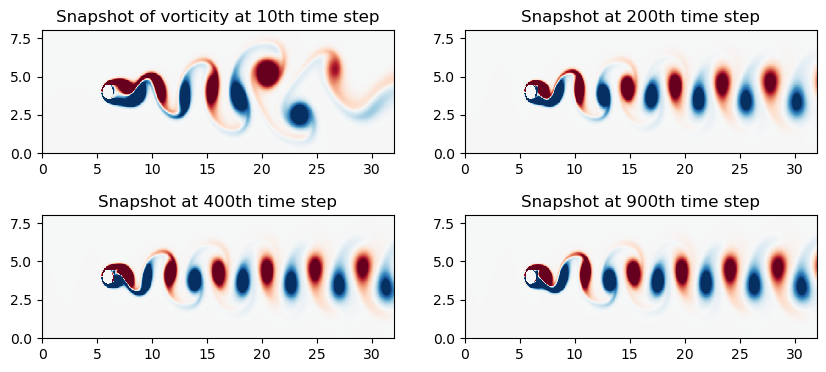

In [5]:
#Visualizing two of the snapshots of the vorticity field

#One time step (dt) = 0.125s
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.pcolormesh(x,y,np.reshape(U[:,10], (ny,nx)), cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Snapshot of vorticity at 10th time step")
plt.subplot(2,2,2)
plt.pcolormesh(x,y,np.reshape(U[:,200], (ny,nx)), cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Snapshot at 200th time step")
plt.subplot(2,2,3)
plt.pcolormesh(x,y, np.reshape(U[:,400], (ny,nx)), cmap ="RdBu_r", vmin=-1, vmax=1)
plt.title("Snapshot at 400th time step")
plt.subplot(2,2,4)
plt.pcolormesh(x,y, np.reshape(U[:,999], (ny,nx)), cmap="RdBu_r", vmin=-1, vmax=1)
plt.title("Snapshot at 900th time step")

plt.subplots_adjust(hspace=0.5)
plt.show()

In [6]:
X = U.astype(np.float32)

# 1) compute temporal mean and center data
mean_field = np.mean(X, axis=1, keepdims=True)  
Xc = X - mean_field                               # centered fluctuations

# 2) compute small correlation matrix C = Xc^T Xc  (shape n_time x n_time)
print("Forming correlation matrix C (size: {}x{}) ...".format(n_time, n_time))
C = (Xc.T @ Xc)   # you can scale by 1/(n_time-1) if you want normalized cov

# 3) eigen-decompose C (method-of-snapshots). Use eigh for symmetric matrix
eigvals, eigvecs = eigh(C)    # ascending order
# reorder descending
idx = eigvals.argsort()[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

# 4) singular values and modal energies
tol = 1e-12
eigvals_clipped = np.clip(eigvals, a_min=0, a_max=None)
singular_vals = np.sqrt(eigvals_clipped)
total_energy = np.sum(singular_vals**2)
energies = (singular_vals**2) / total_energy
cum_energy = np.cumsum(energies)

# 5) compute spatial POD modes U_pod = Xc @ V @ Sigma^{-1}
# avoid division by zero for tiny singular values
nonzero = singular_vals > tol
r_max = np.sum(nonzero)
print(f"Non-zero POD modes available: {r_max}")
S_inv = np.zeros_like(singular_vals)
S_inv[nonzero] = 1.0 / singular_vals[nonzero]
# modes shape: (n_points, n_time) but only first r_max are meaningful
modes = (Xc @ eigvecs) * S_inv[np.newaxis, :]   # broadcasting; columns are POD modes
# keep only r_max columns
modes = modes[:, :r_max]
singular_vals = singular_vals[:r_max]
energies = energies[:r_max]
cum_energy = cum_energy[:r_max]

# 6) modal time coefficients (amplitudes): a = U^T Xc  => shape (r_max, n_time)
coeffs = modes.T @ Xc 



Forming correlation matrix C (size: 1000x1000) ...
Non-zero POD modes available: 918


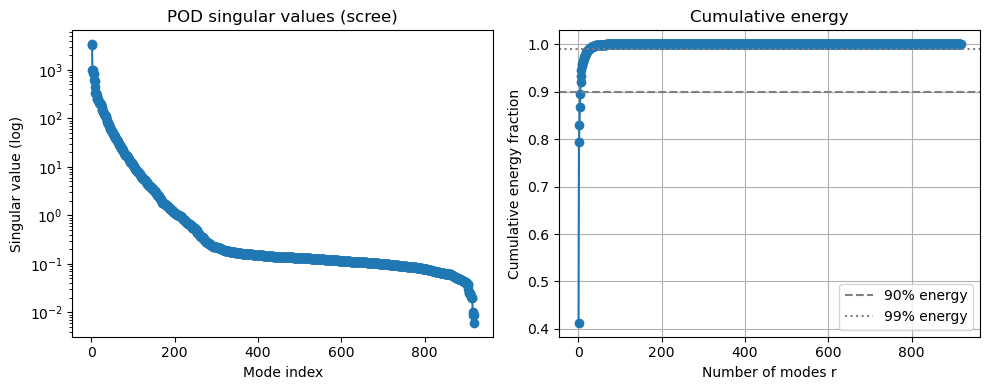

Modes for 90% energy: r90=6, 95%: r95=9, 99%: r99=26


In [7]:
os.makedirs("pod_outputs", exist_ok=True)

# Plot 1: singular values (scree) and energy decay
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.semilogy(np.arange(1, r_max+1), singular_vals, 'o-')
plt.xlabel('Mode index')
plt.ylabel('Singular value (log)')
plt.title('POD singular values (scree)')

plt.subplot(1,2,2)
plt.plot(np.arange(1, r_max+1), cum_energy, 'o-')
plt.xlabel('Number of modes r')
plt.ylabel('Cumulative energy fraction')
plt.grid(True)
plt.title('Cumulative energy')
plt.axhline(0.9, color='gray', linestyle='--', label='90% energy')
plt.axhline(0.99, color='gray', linestyle=':', label='99% energy')
plt.legend()
plt.tight_layout()
plt.savefig("pod_outputs/scree_and_cumulative_energy.png", dpi=200)
plt.show()

# Suggest r by energy thresholds
r90 = np.searchsorted(cum_energy, 0.90) + 1
r95 = np.searchsorted(cum_energy, 0.95) + 1
r99 = np.searchsorted(cum_energy, 0.99) + 1
print(f"Modes for 90% energy: r90={r90}, 95%: r95={r95}, 99%: r99={r99}")


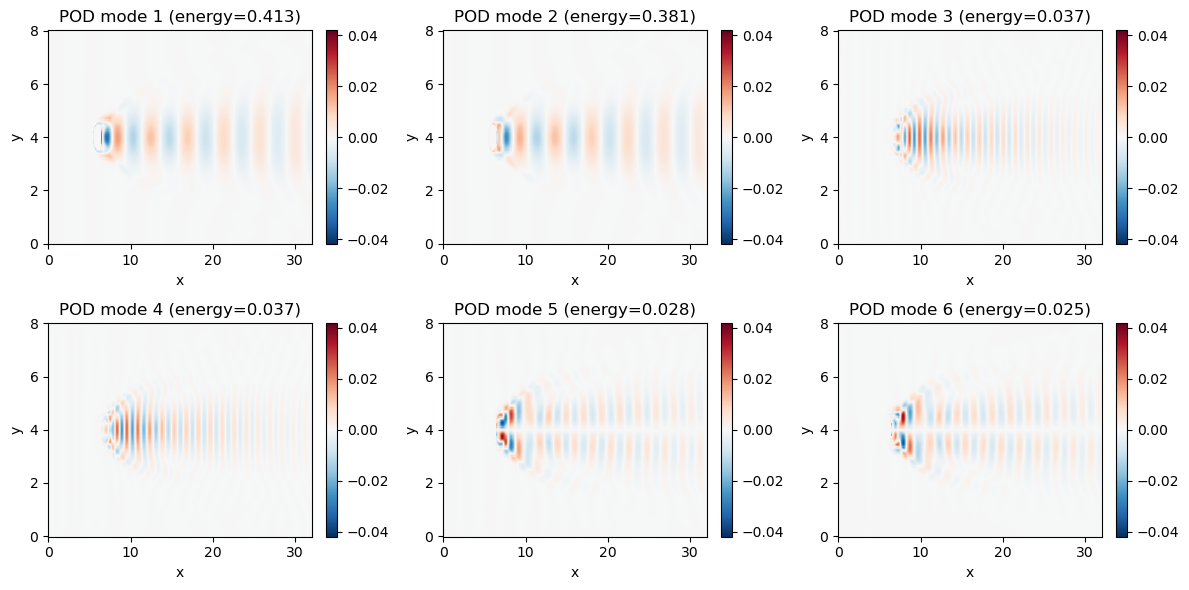

In [8]:
# Plot 2: first 6 spatial POD modes (reshape to (ny,nx))
n_show_modes = 6
vmax_mode = np.max(np.abs(modes[:, :n_show_modes]))
plt.figure(figsize=(12,6))
for i in range(n_show_modes):
    ax = plt.subplot(2, 3, i+1)
    mode2d = modes[:, i].reshape((ny, nx))
    pcm = ax.pcolormesh(x, y, mode2d, shading='auto', cmap='RdBu_r',
                        vmin=-vmax_mode, vmax=vmax_mode)
    ax.set_title(f"POD mode {i+1} (energy={energies[i]:.3f})")
    ax.set_xlabel('x'); ax.set_ylabel('y')
    plt.colorbar(pcm, ax=ax, fraction=0.046)
plt.tight_layout()
plt.savefig("pod_outputs/first_6_pod_modes.png", dpi=200)
plt.show()

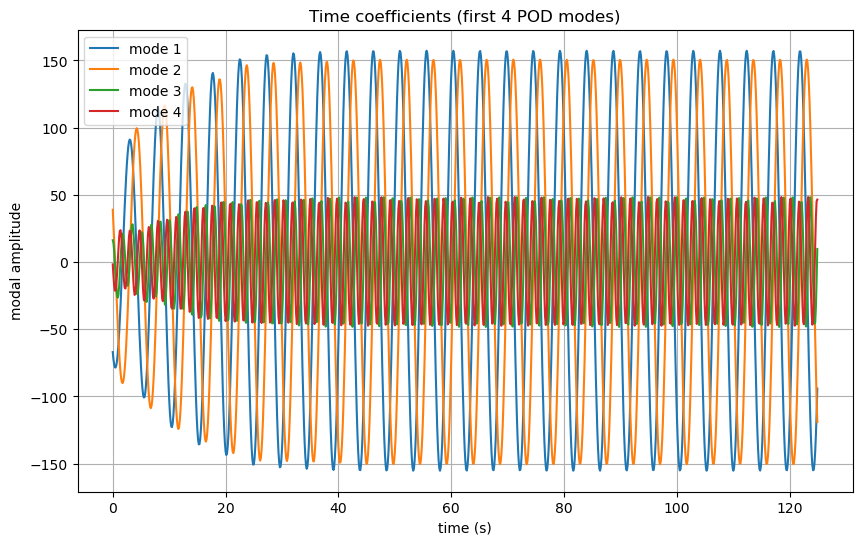

In [9]:
# Plot 3: time coefficients of first 4 modes
dt = 0.125
plt.figure(figsize=(10,6))
t = np.arange(n_time) * dt
for i in range(4):
    plt.plot(t, coeffs[i, :].real, label=f"mode {i+1}")
plt.xlabel('time (s)')
plt.ylabel('modal amplitude')
plt.title('Time coefficients (first 4 POD modes)')
plt.legend()
plt.grid(True)
plt.savefig("pod_outputs/coeffs_first4.png", dpi=200)
plt.show()

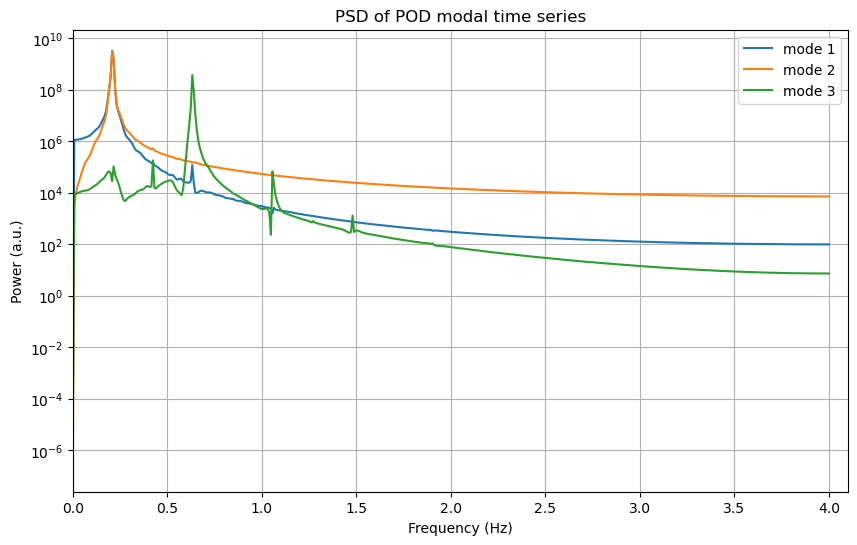

In [10]:
# Plot 4: PSD of first 3 modal coefficients (to identify dominant frequencies)
from numpy.fft import rfft, rfftfreq
plt.figure(figsize=(10,6))
nfft = n_time
freqs = rfftfreq(nfft, dt)   # in Hz
for i in range(3):
    spec = np.abs(rfft(coeffs[i, :].real))**2
    plt.semilogy(freqs, spec, label=f"mode {i+1}")
plt.xlim(0, 4.1)  # Nyquist = 1/(2*dt) = 4 Hz for dt=0.125
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (a.u.)')
plt.title('PSD of POD modal time series')
plt.legend()
plt.grid(True)
plt.savefig("pod_outputs/psd_first3_modes.png", dpi=200)
plt.show()